In [26]:
import numpy as np
from matplotlib import pyplot as plt
from time import time
import os
import cv2
from skimage import color
import matplotlib.patches as patches

############################################### file loading related methods ###############################################

def load_img(path):
    """
    load image from path
    path: input path of image
    """
    return cv2.imread(path)

def get_all_top_image_paths(root='../data/processed_data/'):
    return [root+x for x in os.listdir(root) if 'top' in x and 'copper' not in x]

def get_all_copper_image_paths(root='../data/processed_data/'):
    return [root+x for x in os.listdir(root) if 'top' in x and 'copper' in x]

In [2]:
import xml.etree.ElementTree as ET
import os
import matplotlib.pyplot as plt
import collections
import cv2
import numpy as np


def get_all_label_paths(root='../data/labels/'):
    return [root+x for x in os.listdir(root)]

def get_all_bounding_box_from_file(path):
    """
    return: list of pair (bounding_box, label)
    """
    root = ET.parse(path).getroot()
    res = []
    for member in root.findall('object'):
        label = member.find('name').text
        box = member.find('bndbox')
        bounding_box = [int(box[i].text) for i in range(4)]
        res.append((bounding_box, label))
    return res

In [3]:
all_label_files = get_all_label_paths()
get_all_bounding_box_from_file(all_label_files[0])

[([61, 179, 209, 295], 'power_supply'),
 ([304, 301, 352, 332], 'regulation'),
 ([392, 59, 448, 92], 'capacitance'),
 ([579, 109, 625, 130], 'LED'),
 ([483, 269, 655, 298], 'resistance'),
 ([708, 344, 763, 377], 'capacitance')]

In [4]:
def in_box(bounding_box, pos, tol=0):
    """
    tol: tolerance of bounding box boundary
    return: whether the position is inside the bounding box
    """
    
    return bounding_box[0]-tol <= pos[1] <= bounding_box[2]+tol and bounding_box[1]-tol <= pos[0] <= bounding_box[3]+tol # coordinate space are swapped

In [16]:
def get_all_connected_pixels(img, start_pos):
    """
    Two pixels are called connected if there is a sequence of intermediate pixels that are exactly the same and are adjacent to each other
    return: all pixels connected to the start_pos.
    """
    
    queue = collections.deque()
    visited = set()
    pixel = img[start_pos[0]][start_pos[1]]
    queue.append(start_pos)
    visited.add(start_pos)
    
    while queue:
        pos = queue.popleft()
        for i, j in [[pos[0]-1, pos[1]], [pos[0], pos[1]-1], [pos[0]+1, pos[1]], [pos[0], pos[1]+1]]:
            if 0 <= i < len(img) and 0 <= j < len(img[0]) and (i, j) not in visited and img[i][j] == pixel:
                queue.append((i, j))
                visited.add((i, j))
    return visited


def display_by_marking(img, target_ixs, color=(255, 0, 0)):
    """
    Display the image after marking pixels as ixs to the target color
    """
    img = np.array(img)
    for i, j in target_ixs:
        img[i, j] = color
    fig, ax = plt.subplots(1)
    plt.imshow(img, cmap='gray')
    return ax

In [17]:
processed_path = '../data/processed_data/'
all_top_imgs = [load_img(processed_path+x) for x in os.listdir(processed_path) if 'top' in x and 'copper' not in x]
all_top_copper_imgs = [load_img(processed_path+x) for x in os.listdir(processed_path) if 'top' in x and 'copper' in x]

In [18]:
def to_binary_copper(img):
    """
    img: input copper img in numpy format
    return: binary image 
    """
    return np.array(img[:, :, 0] > 0.5).astype('int')

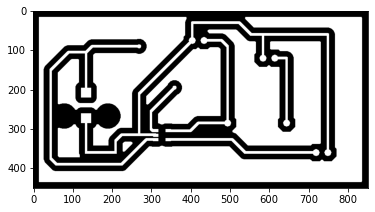

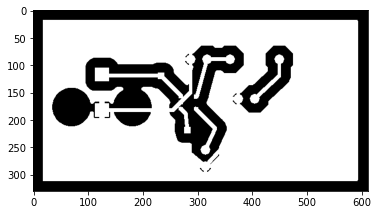

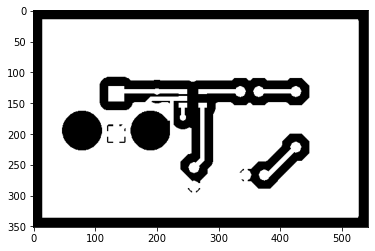

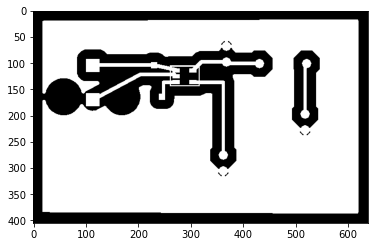

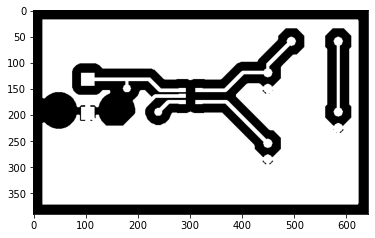

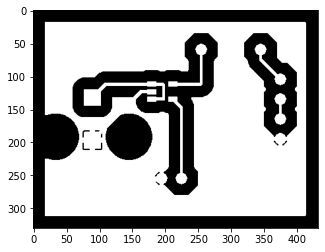

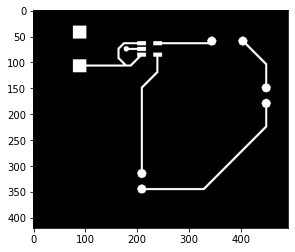

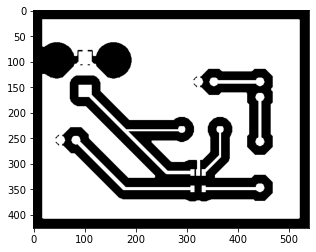

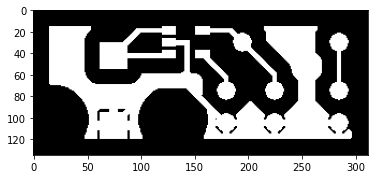

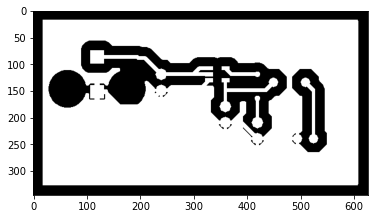

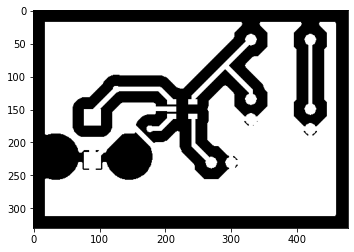

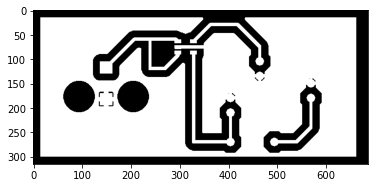

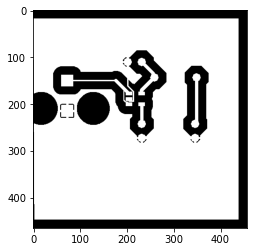

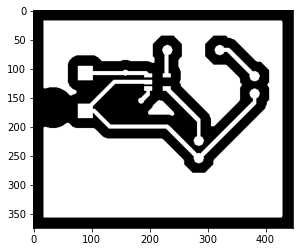

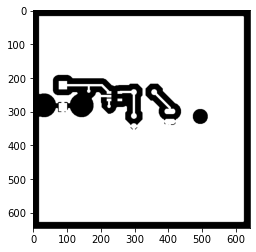

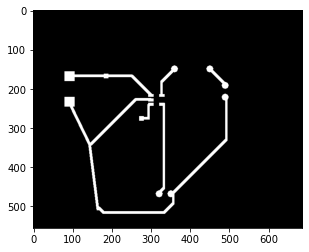

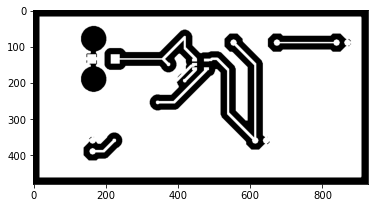

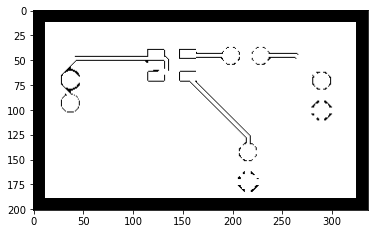

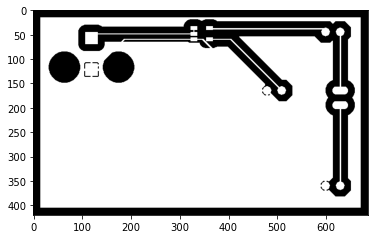

In [19]:
for i in range(len(all_top_copper_imgs)):
    plt.figure()
    plt.imshow(to_binary_copper(all_top_copper_imgs[i]), cmap='gray')

In [20]:
def area_coverage(img, points):
    """
    Calculate IOU with tightest bounding box
    """
    min_row = min(p[0] for p in points)
    min_col = min(p[1] for p in points)
    max_row = max(p[0] for p in points)
    max_col = max(p[1] for p in points)
    
    intersection = len(points)
    union = (max_row-min_row+1)*(max_col-min_col+1)
    return intersection/union


def detect_traces(img):
    """
    img: input copper image in numpy format
    return: list of [points contained in each trace]
    """
    img = to_binary_copper(img)
    visited = set()
    res = []
    for i in range(len(img)):
        for j in range(len(img[0])):
            if img[i][j] == 1 and (i, j) not in visited:
                all_connected = get_all_connected_pixels(img, (i, j))
                if area_coverage(img, all_connected) < 0.3:
                    res.append(all_connected)
                visited = visited.union(all_connected)
    return res

# Detect traces

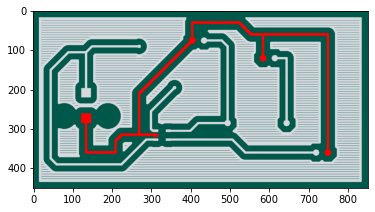

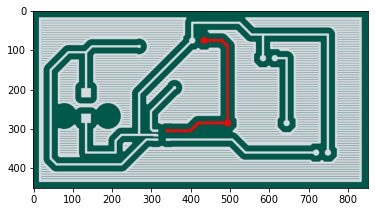

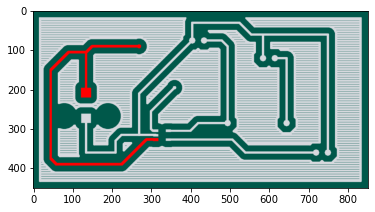

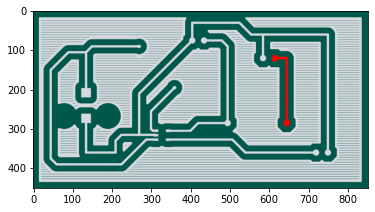

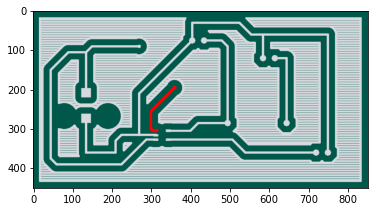

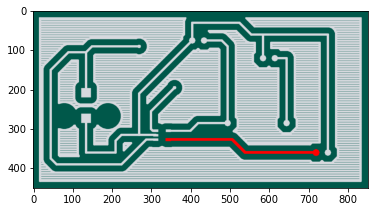

In [21]:
for trace in detect_traces(all_top_copper_imgs[0]):
    display_by_marking(all_top_copper_imgs[0], trace, color=(255, 0, 0))

In [61]:
def get_topology(copper_img, component_bbs, verbose=False):
    """
    copper_img: input copper img in numpy format
    component_bbs: loaded label file in bounding box format
    """
    graph = collections.defaultdict(set)
    for trace in detect_traces(copper_img):
        all_labels = set()
        for i, j in trace:
            for bounding_box, label in component_bbs:
                if in_box(bounding_box, (i, j)):
                    all_labels.add(label)
        if verbose:
            ax = display_by_marking(copper_img, trace, color=(255, 0, 255))
            
            for bix in range(len(component_bbs)):
                box, label = component_bbs[bix]
                width, height = (box[2] - box[0]), (box[3] - box[1])
                initial_pos = (box[0], box[1])
                rect = patches.Rectangle(initial_pos,  width, height, linewidth=1,
                                         edgecolor='cyan', facecolor='none')
                ax.text(box[0] + 5, box[1] - 5, '{}'.format(label), color='red')
                ax.add_patch(rect)
                ax.set_title(f'{all_labels}')
            
        for label_a in all_labels:
            for label_b in all_labels:
                if label_a != label_b:
                    graph[label_a].add(label_b)
                    graph[label_b].add(label_a)
    return graph
        
def get_topology_from_path(copper_path, label_path, verbose=False):
    copper_img = cv2.imread(copper_path)
    component_bbs = get_all_bounding_box_from_file(label_path)
    return get_topology(copper_img, component_bbs, verbose)

defaultdict(set,
            {'power_supply': {'LED', 'capacitance', 'regulation'},
             'LED': {'capacitance',
              'power_supply',
              'regulation',
              'resistance'},
             'capacitance': {'LED',
              'power_supply',
              'regulation',
              'resistance'},
             'regulation': {'LED',
              'capacitance',
              'power_supply',
              'resistance'},
             'resistance': {'LED', 'capacitance', 'regulation'}})

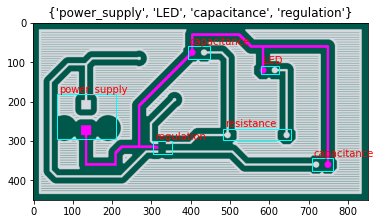

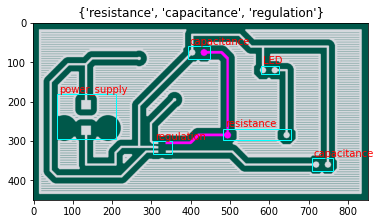

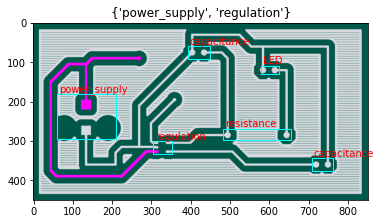

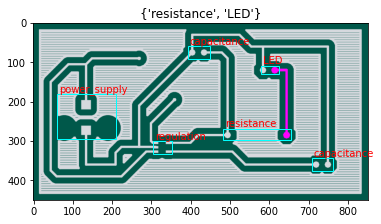

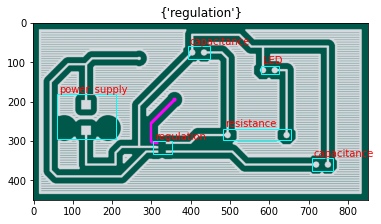

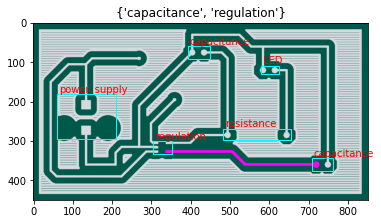

In [62]:
all_top_copper_files = get_all_copper_image_paths()
all_top_copper_label_pairs =  list(zip(sorted(all_top_copper_files), sorted(all_label_files)))
get_topology_from_path(*all_top_copper_label_pairs[0], verbose=True)

defaultdict(set,
            {'resistance': {'LED', 'capacitance', 'regulation'},
             'capacitance': {'regulation', 'resistance'},
             'regulation': {'capacitance', 'resistance'},
             'LED': {'resistance'}})

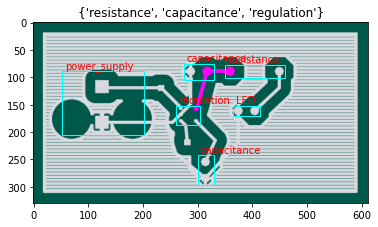

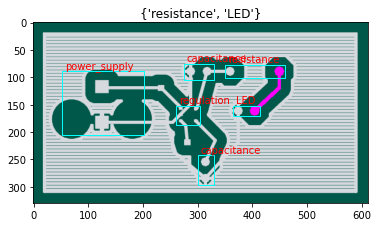

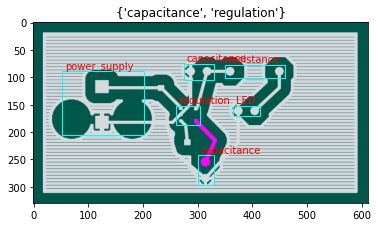

In [63]:
get_topology_from_path(*all_top_copper_label_pairs[1], verbose=True)

defaultdict(set,
            {'power_supply': {'regulation'},
             'regulation': {'capacitance', 'power_supply', 'resistance'},
             'resistance': {'LED', 'regulation'},
             'LED': {'capacitance', 'resistance'},
             'capacitance': {'LED', 'regulation'}})

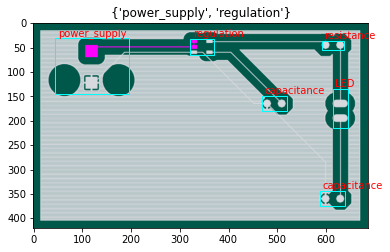

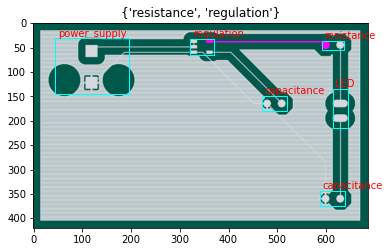

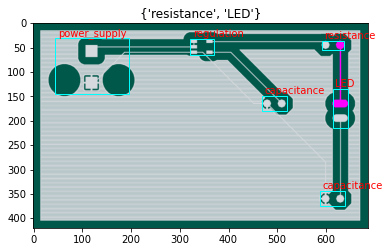

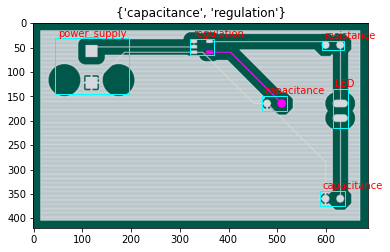

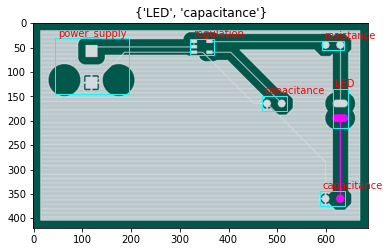

In [64]:
get_topology_from_path(*all_top_copper_label_pairs[-1], verbose=True)

# Negative example

In [65]:
get_topology_from_path(*all_top_copper_label_pairs[-2], verbose=True)

defaultdict(set, {})

Missing resistance LED


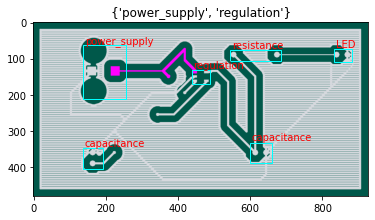

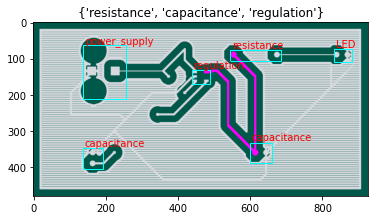

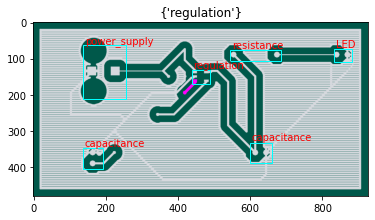

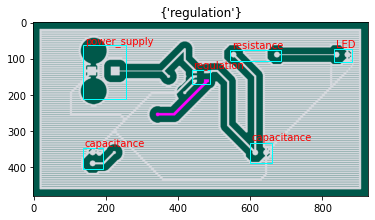

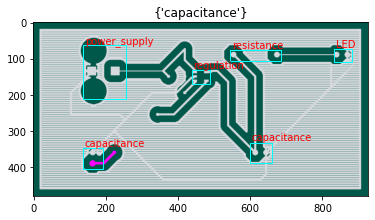

In [67]:
get_topology_from_path(*all_top_copper_label_pairs[-3], verbose=True)
print('Missing resistance LED')